In [1]:
import cv2                  # for resizing the images
import numpy as np
import os                   # provides functions for interacting with os and directories
from random import shuffle  # mixing up data
from tqdm import tqdm       # percentage barfor tasks


In [16]:
TRAIN_DIR = 'D:\\Cats_vs_Dogs_Classification\\dogs-vs-cats-redux-kernels-edition\\train'
TEST_DIR = 'D:\\Cats_vs_Dogs_Classification\\dogs-vs-cats-redux-kernels-edition\\test'
IMG_SIZE = 50 # 50 X 50
LR = 1e-3  # learning rate

MODEL_NAME = "dogsvscats-{}-{}.model".format(LR,'6conv-basic-video')  # LR-Learning rate

In [3]:
# labelling cat and dog

def label_img(img):
    word_label = img.split('.')[-3]   # dog.13.png (dog=3rd,13=2nd,png=1st)
    if word_label == 'cat' : return [1,0]
    elif word_label == 'dog' : return [0,1]

In [4]:
# training data

def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)  # save an array to a binary file in .npy format
    return training_data

In [5]:
# testing data
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),img_num])
    np.save('test_data.npy',testing_data)
    return testing_data    
        

In [6]:
train_data = create_train_data()
# If you have already created the dataset
# train_data = np.load('train_data.npy')

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:19<00:00, 96.40it/s]
C:\Users\Shreya Sandal\Miniconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [7]:
import tflearn 
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
# tf.reset_default_graph()     # function deprecated
tf.compat.v1.reset_default_graph()

# Input layer

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1],name = 'input')

# 5 layers of convolution and pooling

convnet = conv_2d(convnet, 32, 2, activation = 'relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation = 'relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 128, 2, activation = 'relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

# Fully connected layer

convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)

# Output layer

convnet = fully_connected(convnet, 2, activation = 'softmax')
convnet = regression(convnet, optimizer = 'adam', learning_rate = LR, loss = 'categorical_crossentropy', name = 'targets')

# Create model

model = tflearn.DNN(convnet, tensorboard_dir = 'log')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from C:\Users\Shreya Sandal\dogsvscats-0.001-6conv-basic-video.model
model loaded!


In [9]:
train = train_data[:-500] # all data except last 500 
test = train_data[-500:]  # all data from 500 onwards

In [10]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [11]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 2297  | total loss: 0.27766 | time: 152.636s
| Adam | epoch: 003 | loss: 0.27766 - acc: 0.8876 -- iter: 24448/24500
Training Step: 2298  | total loss: 0.26963 | time: 154.040s
| Adam | epoch: 003 | loss: 0.26963 - acc: 0.8895 | val_loss: 0.36260 - val_acc: 0.8580 -- iter: 24500/24500
--
INFO:tensorflow:C:\Users\Shreya Sandal\dogsvscats-0.001-6conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


In [13]:
# To view result we'll be using tensorboard.
# we can start tensorboard through command line or within a notebook. In notebook we use the following line magic: 

%load_ext tensorboard
%tensorboard --logdir log

# In command line:
# tensorboard dev upload --logdir log 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:30<00:00, 407.28it/s]


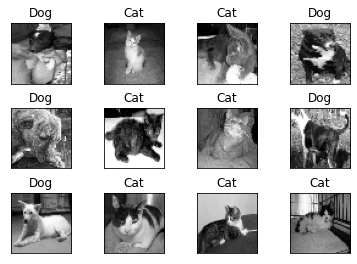

In [21]:
import matplotlib.pyplot as plt

# If you need to create the data:
test_data = process_test_data()

# If you already have saved:
# test_data = np.load('test_data.npy')

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label = 'Dog'
    else: str_label = 'Cat'
    
    y.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()
# plt.tight_layout()